In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
class Individual:
    def __init__(self):
        self.id = None
        self.x = None
        self.y = None
        self.velocity = None
        self.direction = None
        self.state = None
        self.age = None
        self.disease_resistance = None
        self.is_alive = None
        self.possible_states = {'Z' : 2, 'C' : 7, 'ZD' : 5, 'ZZ' : 1000}
        self.state_timer = None
        self.area_bounds = ((0, 100),(0, 100))
        self.had_collided = None

    #włącza się przy ładowaniu osobników
    def set_initial_disease_resistance(self):
        if  15 <= self.age < 40:
            self.disease_resistance = np.random.uniform(6.01, 10.01)
        elif  40 <= self.age < 70:
            self.disease_resistance = np.random.uniform(3.01, 6.01)
        else:
            self.disease_resistance = np.random.uniform(0.01, 3.01)
    #włącza się po każdej turze, przy age_up()
    def set_age_disease_resistance(self):
        if self.age == 15:
            self.disease_resistance = min(self.disease_resistance, 10)
        elif self.age == 40:
            self.disease_resistance = min(self.disease_resistance, 6)
        elif self.age == 70:
            self.disease_resistance = min(self.disease_resistance, 3)
    #przy tworzeniu osobników
    def generate_stats(self, index):
        self.id = index
        self.x = np.random.randint(0,101)
        self.y = np.random.randint(0,101)
        self.velocity = np.random.randint(1, 4)
        self.direction = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        self.state = np.random.choice(list(self.possible_states.keys()))
        self.state_timer = self.possible_states[self.state]
        self.age = np.random.randint(0, 61)
        self.set_initial_disease_resistance()
        self.is_alive = True
        self.had_collided = False
    #dla nowonarodzonych
    def newborn_stats(self, index, parent_x, parent_y):
        self.id = index
        self.x = parent_x + np.random.randint(-2, 2)
        self.y = parent_y + np.random.randint(-2, 2)
        self.velocity = np.random.randint(1, 4)
        self.direction = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        self.state = 'ZZ'
        self.age = 0
        self.disease_resistance = 10
        self.is_alive = True
        self.had_collided = True # ? wtedy urodzone osobniki nie brałyby udziału w spotkaniach na turę urodzin

    def move(self):
        self.x += self.direction[0] * self.velocity
        self.y += self.direction[1] * self.velocity
        if self.x < self.area_bounds[0][0]:
            self.x = self.area_bounds[0][0]
            self.direction = (-self.direction[0], self.direction[1])
        elif self.x > self.area_bounds[0][1]:
            self.x = self.area_bounds[0][1]
            self.direction = (-self.direction[0], self.direction[1])
        if self.y < self.area_bounds[1][0]:
            self.y = self.area_bounds[1][0]
            self.direction = (self.direction[0], -self.direction[1])
        elif self.y > self.area_bounds[1][1]:
            self.y = self.area_bounds[1][1]
            self.direction = (self.direction[0], -self.direction[1])

    def detect_collisions(self, individuals, spawn_chance=0.5):
        if self.had_collided == True:
            return
        for other in individuals:
            if other.id != self.id and self.had_collided == False and other.had_collided == False: #żeby nie sprawdzić siebie
                if max(abs(self.x - other.x), abs(self.y - other.y)) <= 2:
                    #LICZENIE ODPORNOŚCI, DZIECI i ustaw kolizję na true żeby nie można było ponownie skolidować

                    #Narodziny
                    if  20 <= self.age <= 40 and 20 <= other.age <= 40 and spawn_chance > np.random.uniform(0, 1):
                        offspring_amount = np.random.randint(1, 3)
                        for i in range(offspring_amount):
                            new_individual = Individual()
                            #przekaż mu nowy indeks
                            index = len(individuals)
                            parent_x = self.x
                            parent_y = self.y
                            new_individual.newborn_stats(index, parent_x, parent_y)
                            individuals.append(new_individual)
                            print("Nowy osobnik! ", index)

                    #Zmiana odporności
                    if self.state == 'ZZ' and other.state == 'Z':
                        if self.disease_resistance <= 3:
                            self.state = 'Z'
                            self.state_timer = self.possible_states[self.state]
                    elif self.state == 'ZZ' and other.state == 'C':
                        if self.disease_resistance <= 6:
                            self.state = 'Z'
                            self.state_timer = self.possible_states[self.state]
                        else:
                            self.disease_resistance -= 3
                    elif self.state == 'ZZ' and other.state == 'ZD':
                        other.disease_resistance += 1
                    elif self.state == 'ZZ' and other.state == 'ZZ':
                        resistance = 0
                        if 15 <= self.age <= 40:
                            resistance = 10
                        elif 40 <= self.age <= 70:
                            resistance = 6
                        else:
                            resistance = 3
                        self.disease_resistance = max(max(self.disease_resistance, resistance), max(other.disease_resistance, resistance))
                        if 15 <= other.age <= 40:
                            resistance = 10
                        elif 40 <= other.age <= 70:
                            resistance = 6
                        else:
                            resistance = 3
                        other.disease_resistance = max(max(self.disease_resistance, resistance), max(other.disease_resistance, resistance))
                    elif self.state == 'C' and other.state == 'Z':
                        if other.disease_resistance <= 6:
                            other.state = 'Z'
                            other.state_timer = self.possible_states[other.state]

                        self.state_timer = self.possible_states[self.state]
                    elif self.state == 'C' and other.state == 'ZD':
                        if other.disease_resistance <= 6:
                            other.state = 'Z'
                            other.state_timer = self.possible_states[other.state]
                    elif self.state == 'C' and other.state == 'C':
                        self.disease_resistance = min(self.disease_resistance, other.disease_resistance)
                        other.disease_resistance = min(self.disease_resistance, other.disease_resistance)

                        self.state_timer = self.possible_states[self.state]
                        other.state_timer = self.possible_states[other.state]
                    elif self.state == 'Z' and other.state == 'ZD':
                        other.disease_resistance -= 1
                    elif self.state == 'Z' and other.state == 'Z':
                        self.disease_resistance -= 1
                        other.disease_resistance -= 1
                    # ZD I ZD, nic się nie dzieje

                    #koniec, kolizje na true, i zmiana kierunku, skaczą o 3 żeby nie wpaść w ponowną kolizję ze sobą
                    self.direction = (-self.direction[0], -self.direction[1])
                    other.direction = (-self.direction[0], -self.direction[1])
                    self.x = self.x + self.direction[0] * 3
                    self.y = self.y + self.direction[1] * 3

                    other.x = other.x + other.direction[0] * 3
                    other.y = other.y + other.direction[1] * 3

                    self.had_collided = True
                    other.had_collided = True

    def calculate_disease_resistance(self):
        if self.state == 'Z':
            self.disease_resistance -= 0.1
            self.state_timer -= 1
            if self.state_timer == 0:
                self.state = 'C'
                self.state_timer = self.possible_states[self.state]
        elif self.state == 'C':
            self.disease_resistance -= 0.5
            self.state_timer -= 1
            if self.state_timer == 0:
                self.state = 'ZD'
                self.state_timer = self.possible_states[self.state]
        elif self.state == 'ZD':
            max_resistance = 0
            if 15 <= self.age <= 40:
                max_resistance = 10
            elif 40 <= self.age <= 70:
                max_resistance = 6
            else:
                max_resistance = 3
            self.disease_resistance += 0.1
            self.disease_resistance = np.clip(self.disease_resistance, a_min=0, a_max = max_resistance)
            self.state_timer -= 1
            if self.state_timer == 0:
                self.state = 'ZZ'
        elif self.state == 'ZZ':
            max_resistance = 0
            if 15 <= self.age <= 40:
                max_resistance = 10
            elif 40 <= self.age <= 70:
                max_resistance = 6
            else:
                max_resistance = 3
            self.disease_resistance += 0.05
            self.disease_resistance = np.clip(self.disease_resistance, a_min=0, a_max = max_resistance)

        if self.disease_resistance <= 0:
            self.is_alive = False


    def age_up(self):
        self.age += 1
        if self.age >= 100:
            self.is_alive = False
        else:
            self.set_age_disease_resistance()

    def show_stats(self):
        print(f"x: {self.x}, y: {self.y}, velocity: {self.velocity}, direction: {self.direction}, state: {self.state}, age: {self.age}, disease_resistance: {self.disease_resistance}, is_alive: {self.is_alive}")



Nowy osobnik!  92
Nowy osobnik!  90
Nowy osobnik!  91
Nowy osobnik!  88
Nowy osobnik!  89
Nowy osobnik!  88
Nowy osobnik!  87
Nowy osobnik!  88
Nowy osobnik!  87
Nowy osobnik!  88
Nowy osobnik!  85
Nowy osobnik!  86
Nowy osobnik!  83
Nowy osobnik!  84
Nowy osobnik!  83


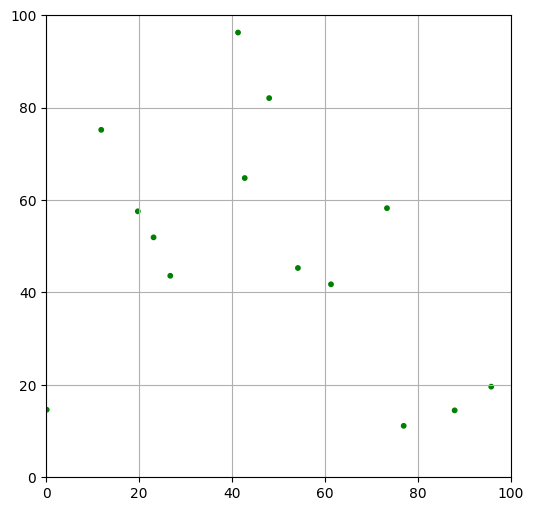

In [ ]:
state_colors = {
    'C': 'red',
    'Z': 'yellow',
    'ZD': 'orange',
    'ZZ': 'green'
}

starting_individuals = 100
amount_of_turns = 100
np.random.seed()

individuals = [Individual() for _ in range(starting_individuals)]
for index, individual in enumerate(individuals):
    individual.generate_stats(index)

fig = plt.figure(figsize=(6, 6))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)

positions = [[ind.x, ind.y] for ind in individuals]
colors = [state_colors[ind.state] for ind in individuals]

sc = plt.scatter([pos[0] for pos in positions], [pos[1] for pos in positions], c=colors, s=10)

def animate(i):
    global individuals
    for ind in individuals:
        ind.had_collided = False
        ind.move()
        ind.detect_collisions(individuals)
        ind.calculate_disease_resistance()
        ind.age_up()
        if ind.is_alive == False:
            individuals.remove(ind)


    individuals = [ind for ind in individuals]
    new_positions = [[ind.x, ind.y] for ind in individuals]
    new_colors = [state_colors[ind.state] for ind in individuals]
    sc.set_offsets(np.array(new_positions).reshape(-1, 2))
    sc.set_color(new_colors)
    return (sc,)

ani = animation.FuncAnimation(fig, animate, frames=amount_of_turns, interval=50)

HTML(ani.to_jshtml())